In [1]:
import pandas as pd  
import numpy as np
from glob import glob
from scipy.io import savemat, loadmat
from datetime import datetime

import seaborn as sns
sns.reset_orig()
import matplotlib.pyplot as plt
import pdb

import psycopg2
import sqlite3
import os

from importlib import reload

import visualizeProfs as vp
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pchipOceanSlices import PchipOceanSlices

#reload(visualizeProfs)

/home/tyler/anaconda3/envs/argo/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/home/tyler/anaconda3/envs/argo/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/home/tyler/anaconda3/envs/argo/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/home/tyler/anaconda3/envs/argo/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/home/tyler/anaconda3/envs/argo/lib/python3.6/_collectio

In [4]:
files = glob('/home/tyler/Kuusela-Stein/Data/Data/**/obsProfResTrendTemp_at10.0*20.mat')
dfkeys =  ['obsProfRes', 'profFloatIDAggrSel', 'profJulDayAggrSel', 'profLatAggrSel', 'profLongAggrSel']

In [5]:
def load_mat_file(file):
    mat = loadmat(file)
    mat['obsProfRes'] = mat['obsProfRes'][0]
    mat['profLatAggrSel'] = mat['profLatAggrSel'][0]
    mat['profLongAggrSel'] = mat['profLongAggrSel'][0]
    mat['profJulDayAggrSel'] = mat['profJulDayAggrSel'].flatten()
    mat['profFloatIDAggrSel'] = mat['profFloatIDAggrSel'].flatten()
    m = { key: mat[key] for key in dfkeys }
    dates = [pd.to_datetime(x[0]) for x in mat['strDate'].flatten()]
    df = pd.DataFrame.from_dict(m)
    df['date'] = dates
    return df

for file in files:
    print(file)
    matDf = load_mat_file(file)

/home/tyler/Kuusela-Stein/Data/Data/10.0/obsProfResTrendTemp_at10.0dbar_5_20.mat


In [6]:
matDf.head()

,obsProfRes,profFloatIDAggrSel,profJulDayAggrSel,profLatAggrSel,profLongAggrSel,date
0,-0.084464,5905680_0,737131.097014,-64.99803,178.81715,2018-03-12 02:19:42
1,-0.596850,5904162_1,735581.465127,-64.99800,224.13600,2013-12-13 11:09:47
2,-0.163354,7900210_0,735998.087465,-64.99675,164.75788,2015-02-03 02:05:57
3,-0.232464,7900210_2,735999.537789,-64.99654,164.75730,2015-02-04 12:54:25
4,0.202808,5903643_224,736663.528576,-64.99200,276.30300,2016-11-29 12:41:09


In [7]:
# find highest residuals
suspectDf = matDf[abs(matDf['obsProfRes']) > 10]
suspectProfs = suspectDf['profFloatIDAggrSel'].tolist()
suspectProfs =  [x.replace(' ', '') for x in suspectDf]
print(suspectDf.shape)
suspectDf.head()

(17, 6)


,obsProfRes,profFloatIDAggrSel,profJulDayAggrSel,profLatAggrSel,profLongAggrSel,date
263553,11.368299,5901884_302,736901.400741,-17.000,150.693,2017-07-25 09:37:04
337434,-31.115840,2902100_104,736460.241667,-7.114,65.755,2016-05-10 05:48:00
366037,-31.604670,2902108_68,736111.254167,-2.647,68.108,2015-05-27 06:06:00
392461,-25.204994,5904877_7,735676.881921,0.000,360.000,2014-03-18 21:09:58
504371,-32.079993,6901740_126,736837.771528,13.825,83.519,2017-05-22 18:31:00


In [8]:
def detect_outlier(res, threshold):
    outliers=[]
    mean = np.mean(res)
    std =np.std(res)
    for idx, y in enumerate(res):
        z_score= (y - mean)/std
        if np.abs(z_score) > threshold:
            outliers.append(idx)
    return outliers

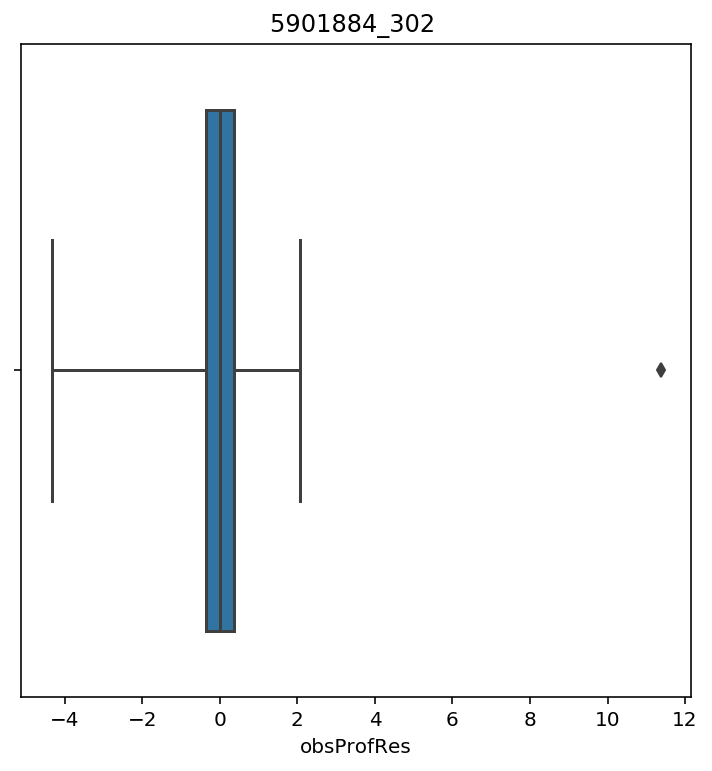

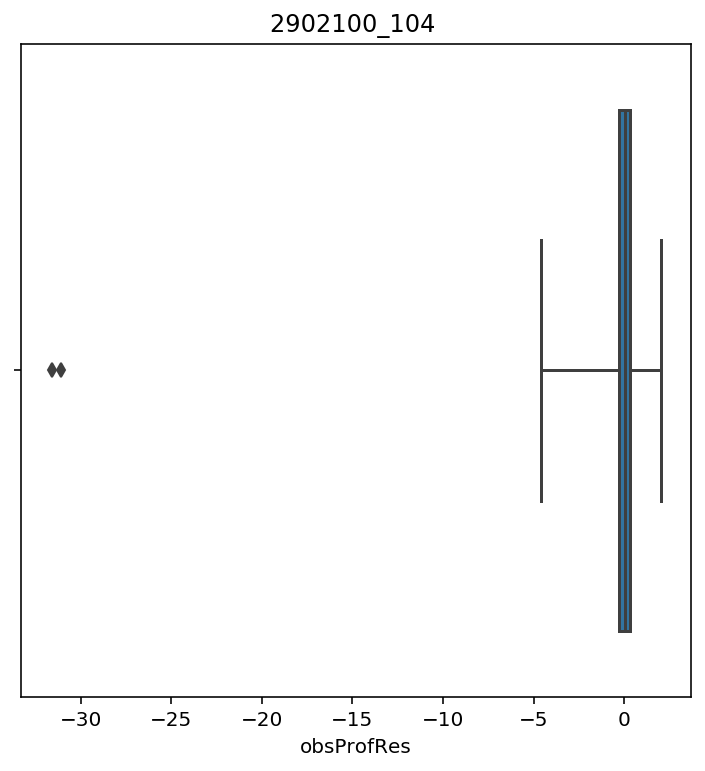

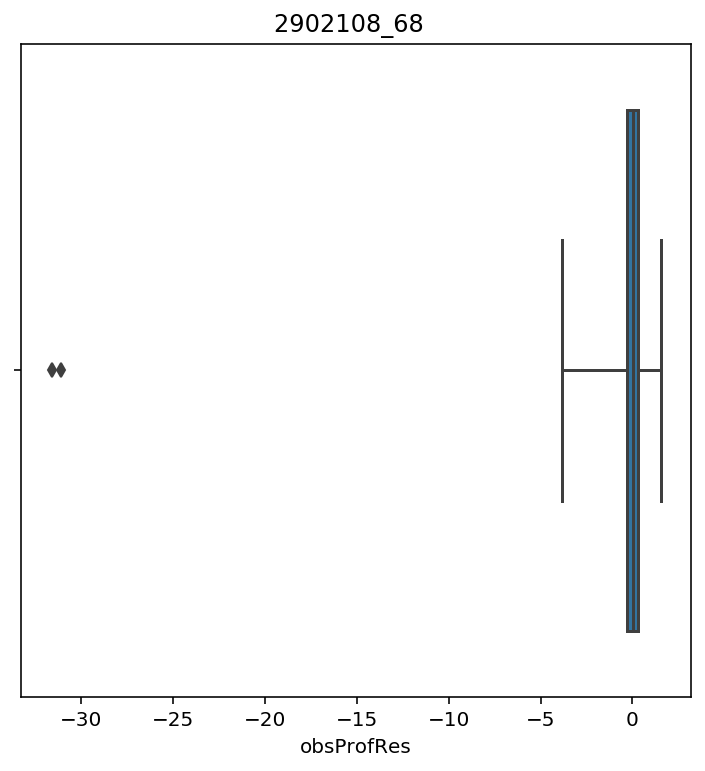

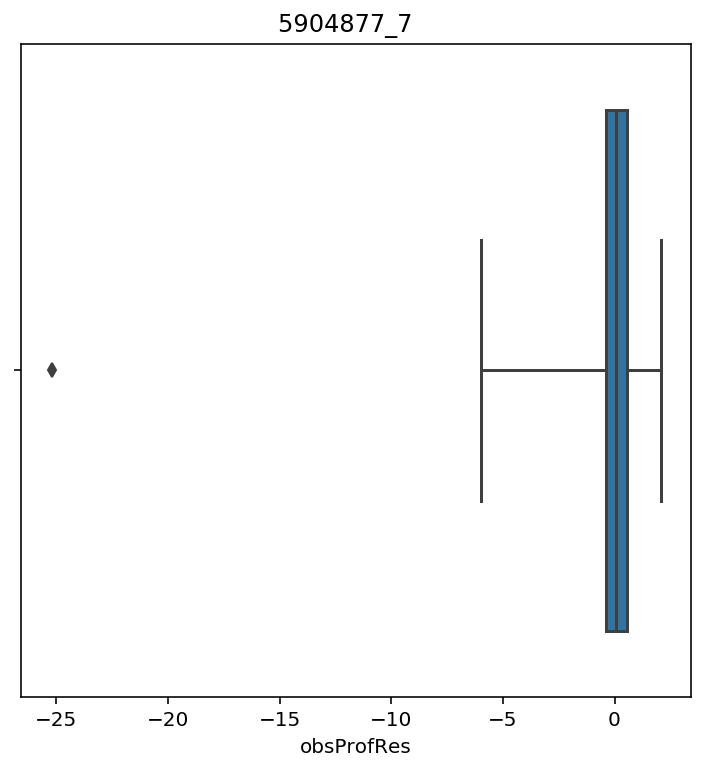

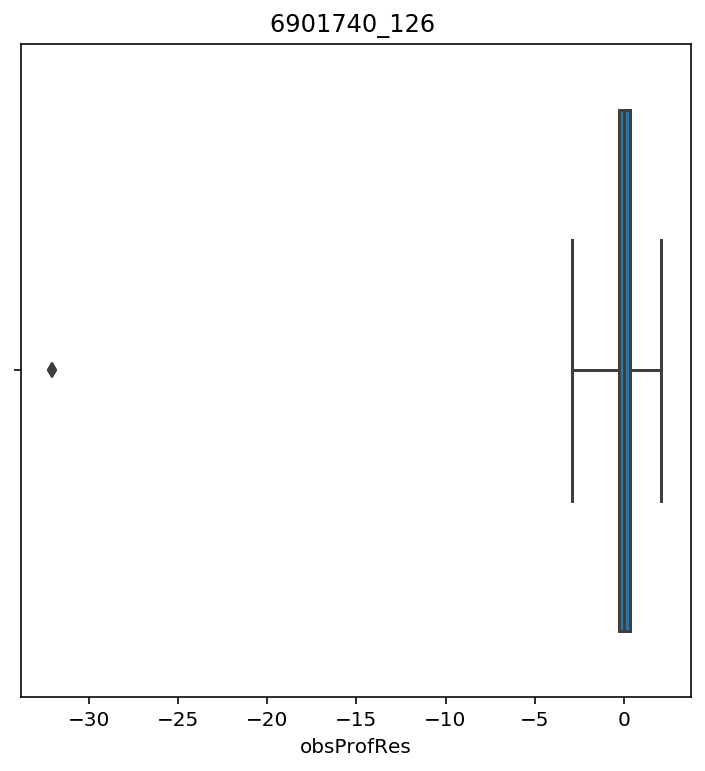

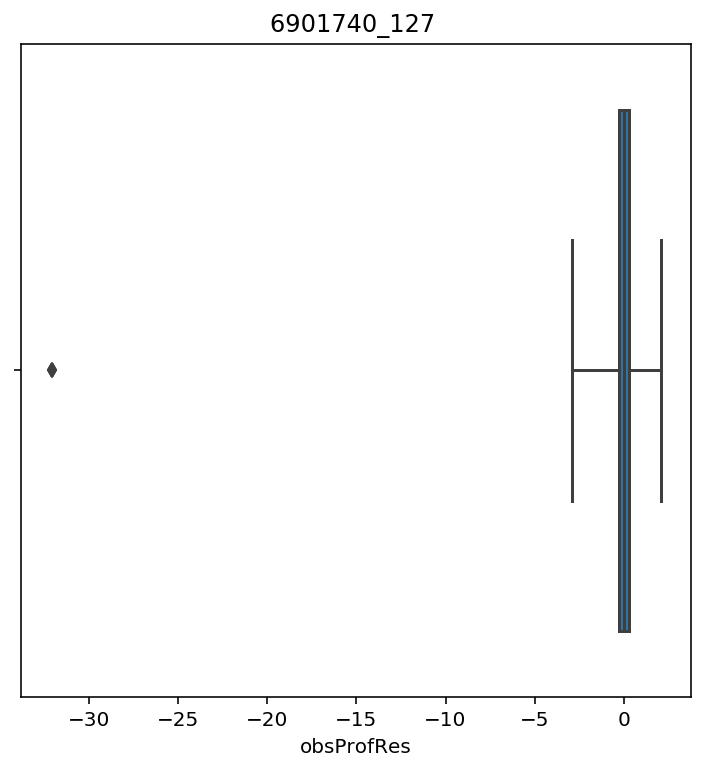

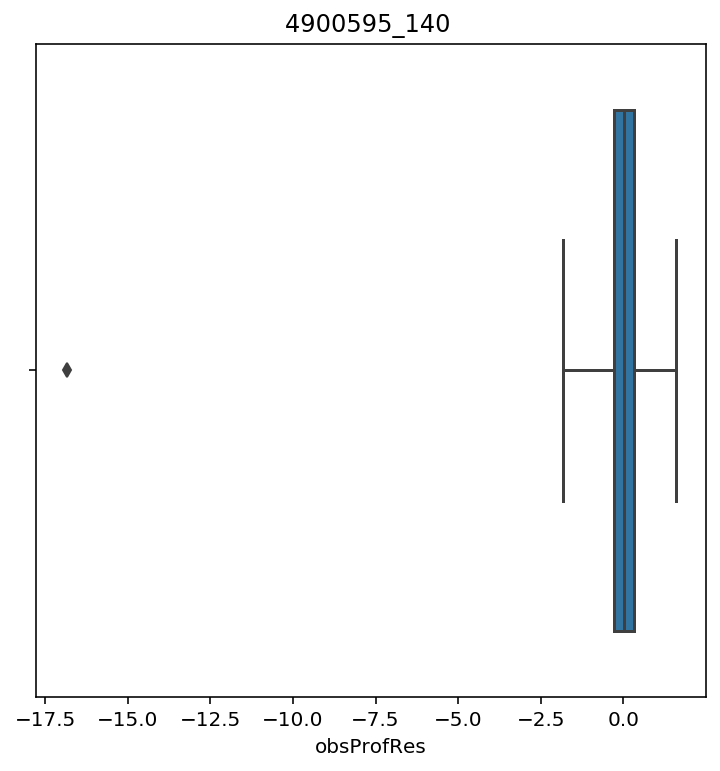

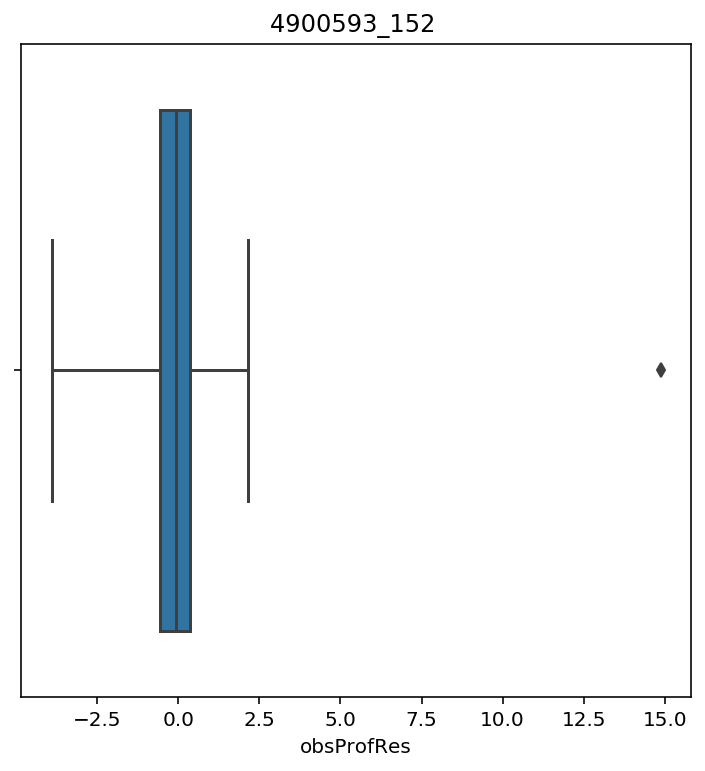

In [9]:
# get surrounding profiles from each row's lat-lon
window = 5 # degree window around outlier
outTH = 8 # n standard deviations away are considered outliers

outlierProfs = []
for row in suspectDf.itertuples():
    lat = row.profLatAggrSel
    long = row.profLongAggrSel
    
    query = (matDf['profLongAggrSel'] >= (long - window)) \
            & (matDf['profLongAggrSel'] <= (long + window)) \
            & (matDf['profLatAggrSel'] >= (lat - window)) \
            & (matDf['profLatAggrSel'] <= (lat + window))
    mdf = matDf[query]
    # construct a hist, with box plot
    
    outliers = []
    outliers = detect_outlier(mdf["obsProfRes"], outTH)
    outlierProfs += mdf['profFloatIDAggrSel'].iloc[outliers].tolist()
    if not len(outliers) == 0:
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
        ax = sns.boxplot(x=mdf["obsProfRes"], whis=outTH)
        title = row.profFloatIDAggrSel
        ax.set_title(title)
#

In [10]:
outlierProfs = [x.replace(' ', '') for x in outlierProfs]

In [11]:
profiles = vp.get_profiles_by_id(str(outlierProfs).replace(' ', ''))
if len(profiles) > 0:
    selectionDf = vp.parse_into_df(profiles)
selectionDf.replace(-999, np.nan, inplace=True)

In [12]:
iCol = 'temp'
xLab = 'pres'
yLab = iCol
xintp = 10
pLevelRange = [5,15]
pos = PchipOceanSlices(pLevelRange)
iDf = pos.make_interpolated_df(selectionDf, xintp, xLab, yLab)
iDf.date = pd.to_datetime(iDf.date)


interpolated value is nan


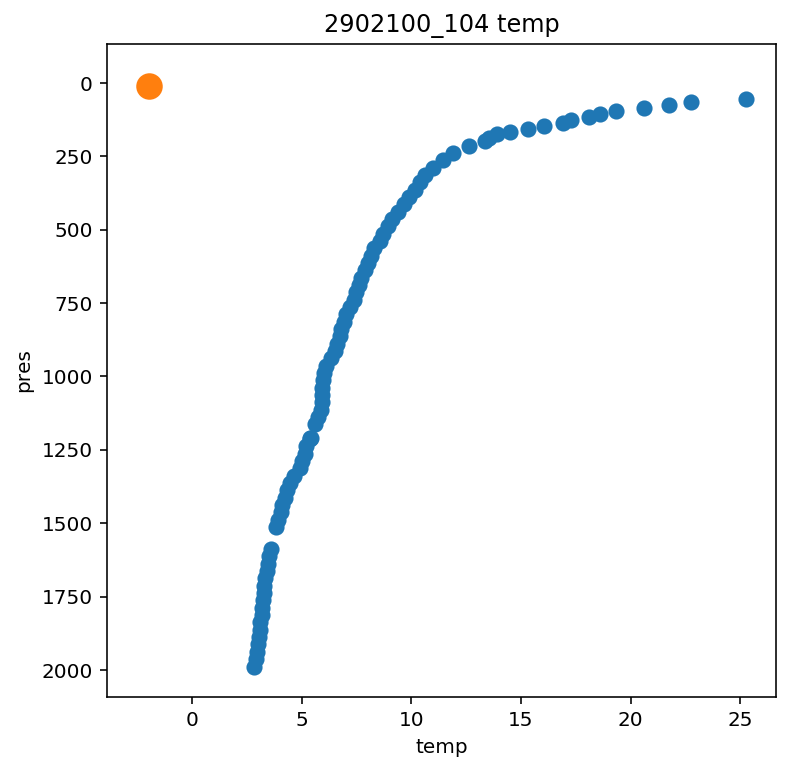

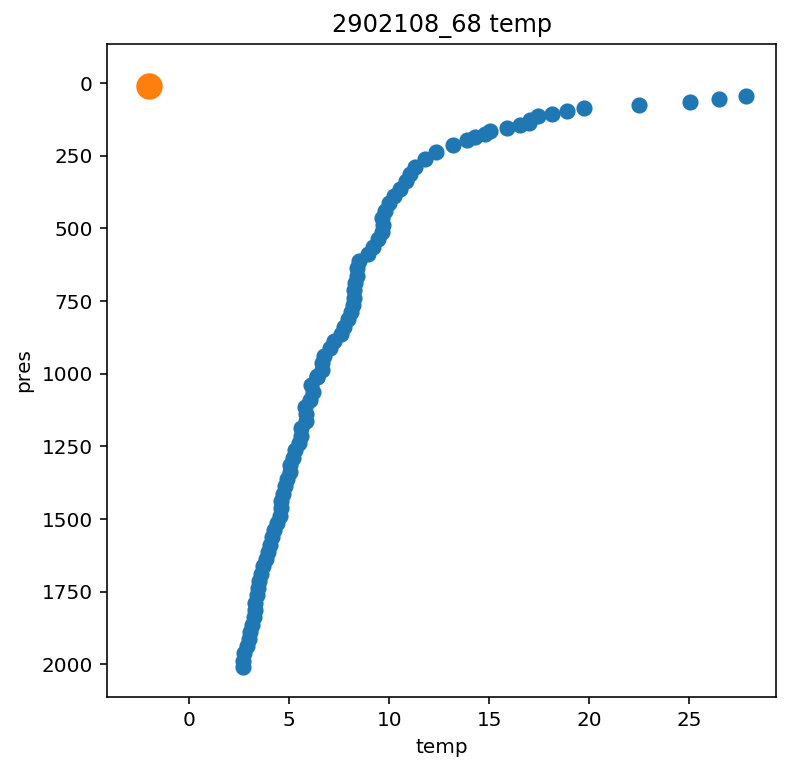

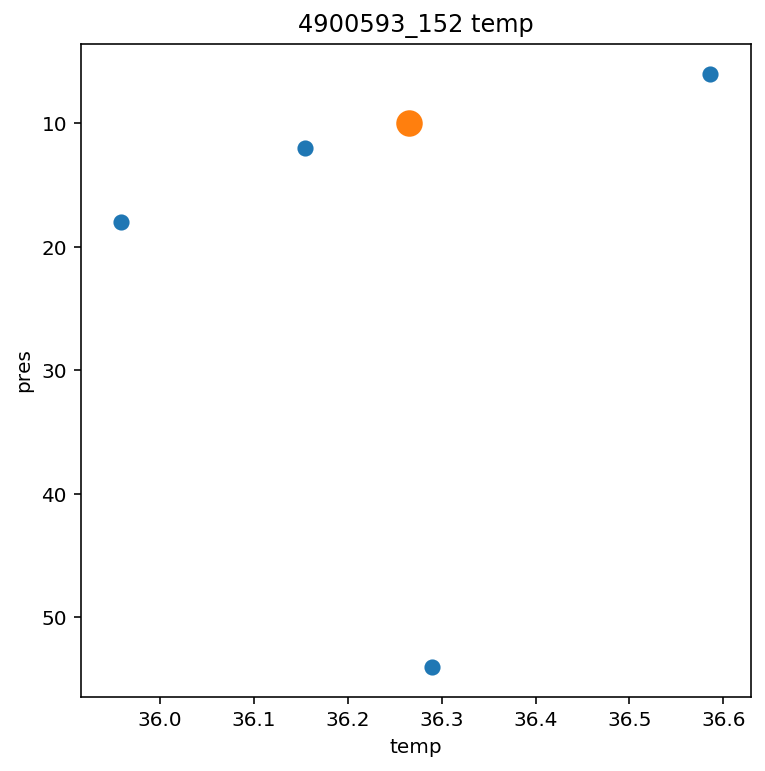

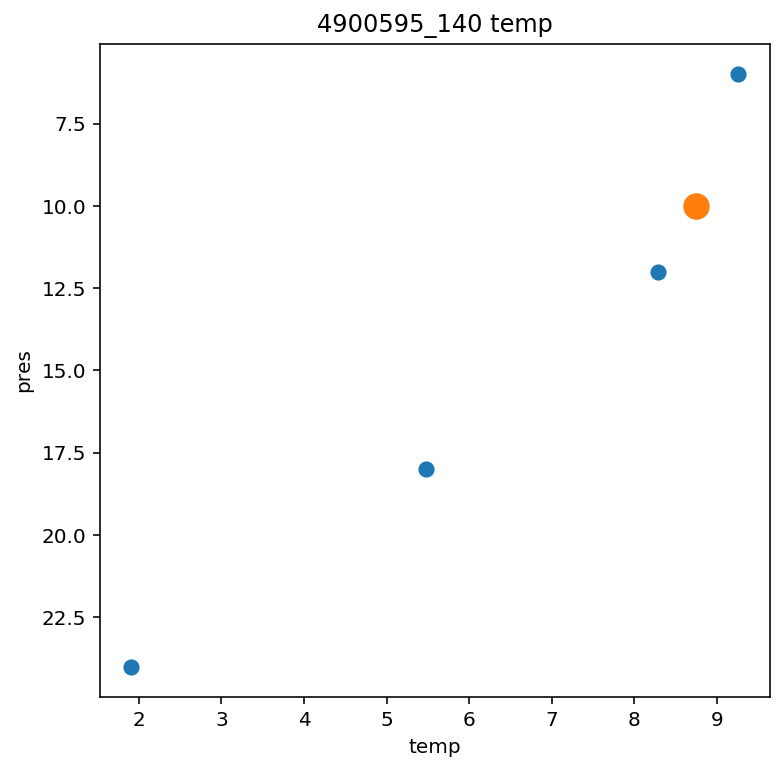

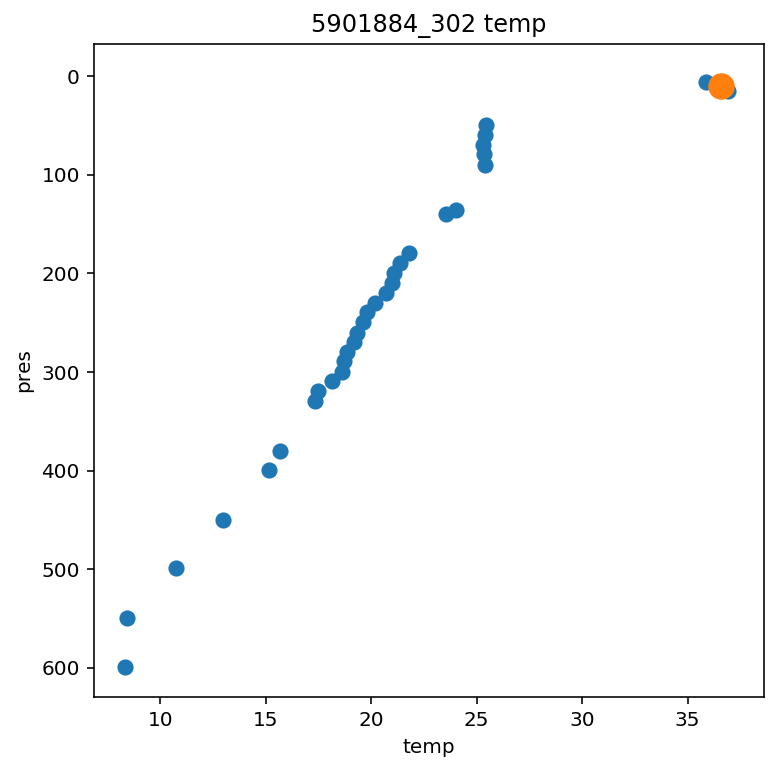

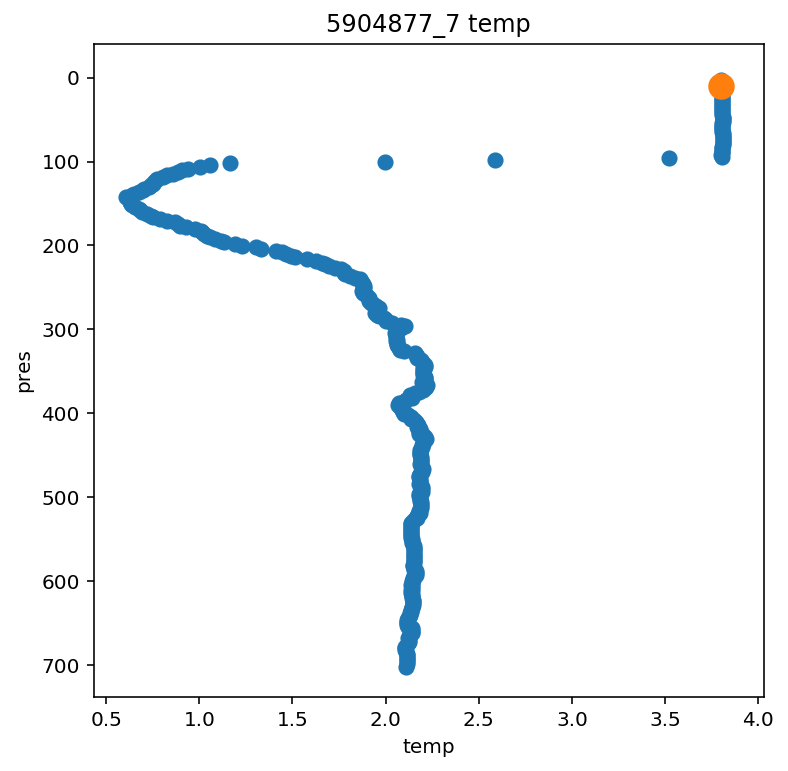

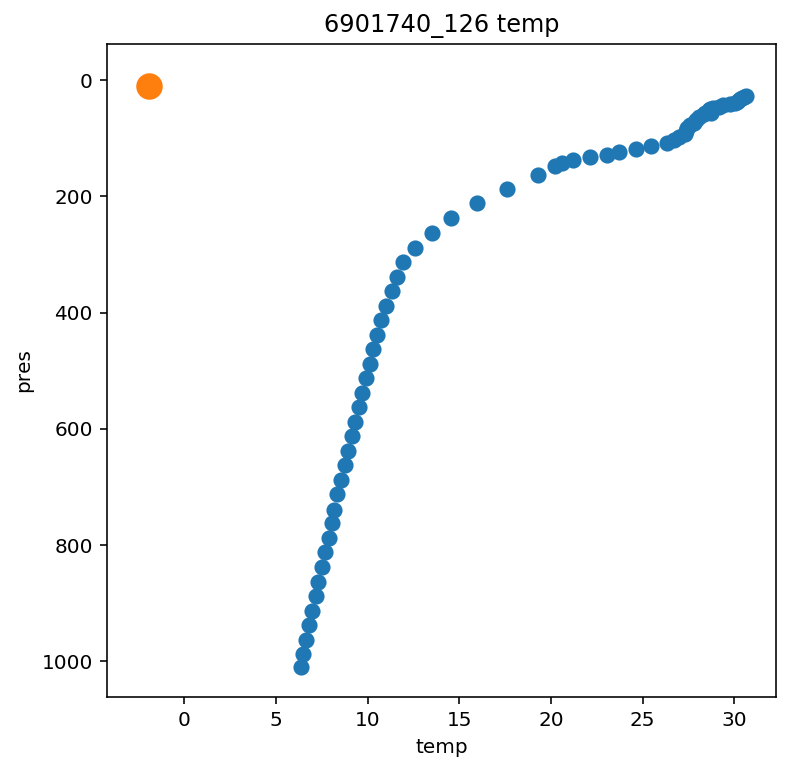

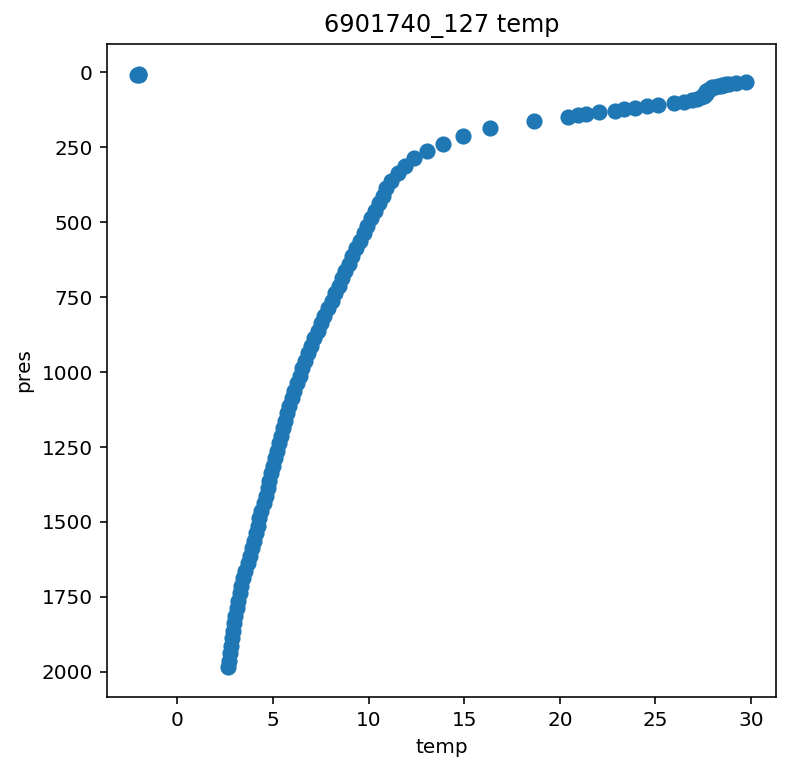

In [13]:
for profile_id, df in selectionDf.groupby('profile_id'):
    #fig.subplots_adjust(hspace=.35, wspace=.35)
    pdf = iDf[iDf['profile_id'] == profile_id]
    iX = pdf[iCol].iloc[0]
    iY = pdf[xLab].iloc[0]
    if pdf.empty or df.empty:
        continue
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
    if profile_id in {'6901002_100', '6901002_101', '6901740_127'} or np.isnan(iX):
        print('interpolated value is nan')
    ax = vp.plot_scatter(df, profile_id, 'temp', 'pres', axes)
    #plt.ylim((20,0))
    ax.scatter(iX, iY, s=150)

In [14]:
print(matDf.columns)
drop_set = {'2902100_104 ', '2902108_68 ', '5901884_302','6901002_126 ', '6901740_127 '}
dropDf = matDf[matDf['profFloatIDAggrSel'].isin(drop_set)]

Index(['obsProfRes', 'profFloatIDAggrSel', 'profJulDayAggrSel',
       'profLatAggrSel', 'profLongAggrSel', 'date'],
      dtype='object')


In [15]:
[latGrid, longGrid] = np.meshgrid(np.linspace(-89.5,89.5,180),
                                  np.linspace(20.5,379.5,360));

In [16]:
gridDf = pd.DataFrame()
gridDf['lat'] = latGrid.flatten('F')
gridDf['long'] = longGrid.flatten('F')
gridDf.index = gridDf.index + 1

In [17]:
round_half = lambda x:  np.round(x-0.5)+0.5;

def make_redo_df(dropDf):
    redoDf = pd.DataFrame()

    for idx, row in dropDf.iterrows():
        lat = round_half(row.profLatAggrSel)
        long = round_half(row.profLongAggrSel)
        latBool = (gridDf['lat'] > lat - 5) & (gridDf['lat'] < lat + 5)
        longBool = (gridDf['long'] > long - 5) & (gridDf['long'] < long + 5)

        redoPoints = gridDf[latBool & longBool]
        redoDf = pd.concat([redoDf, redoPoints], axis=0, sort=False)
    redoDf = redoDf.drop_duplicates(keep='first')
    return redoDf

redoDf = make_redo_df(dropDf)

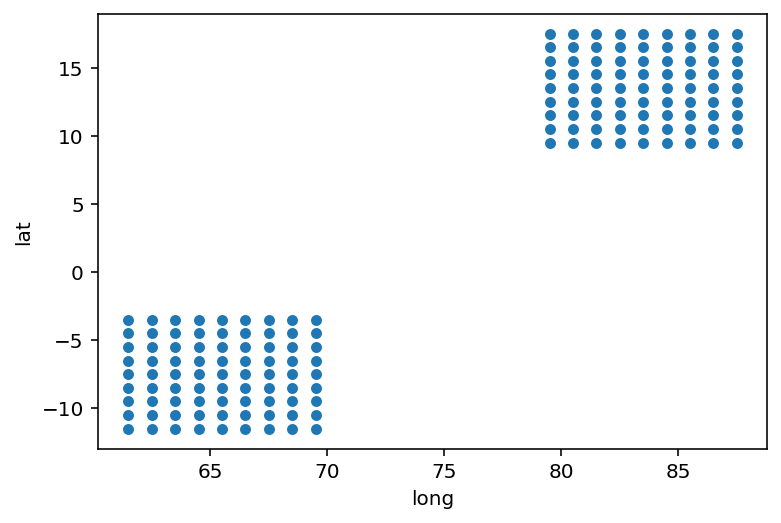

In [18]:
redoDf.plot(kind='scatter', x='long', y='lat')

In [19]:
def save_drop_mat(dropDf, redoDf, file):
    drop_id_list = dropDf.profFloatIDAggrSel.unique().tolist()
    lats = redoDf.lat.tolist()
    longs = redoDf.long.tolist()
    idxs = redoDf.index.tolist()
    a_dict = {'dropLats':lats , 'dropLongs': longs, 'dropIdxs': idxs, 'drop_ids': drop_id_list}
    dirname = os.path.dirname(file)
    redoFileName = 'redo'
    redoFilePath = os.path.join(dirname, redoFileName)
    print(redoFilePath)
    savemat(redoFilePath, a_dict)

In [22]:
save_drop_mat(dropDf, redoDf, file)

/home/tyler/Kuusela-Stein/Data/Data/10.0/redo


In [21]:
savemat(redoFilePath, a_dict)

NameError: name 'redoFilePath' is not defined

In [67]:
asdf  = gridDf[(gridDf['long'] >= long - 5) & (gridDf['long'] <= long + 5)]

In [76]:
redoPoints.long.min()


78.5

In [51]:
gridDf = pd.DataFrame()
gridDf['lat'] = latGrid.flatten('C')
gridDf['long'] = longGrid.flatten('F')

In [52]:
gridDf.head()

,lat,long
0,-89.5,20.5
1,-88.5,21.5
2,-87.5,22.5
3,-86.5,23.5
4,-85.5,24.5
